In [1]:
# Importing the Keras libraries and packages
from keras.utils import np_utils
from keras.models import Sequential, load_model
from keras.layers import Input, Convolution2D, MaxPooling2D, Dense, Dropout, Flatten, BatchNormalization
from keras.callbacks import ModelCheckpoint, CSVLogger, LearningRateScheduler, EarlyStopping
from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
from keras import optimizers

# Importing other necessary libraries
from sklearn.metrics import classification_report,confusion_matrix
from PIL import Image
import matplotlib.pyplot as plt
import multiprocessing as mp
import numpy as np
import h5py, os, itertools, heapq

%config InlineBackend.figure_format = 'retina'
%matplotlib inline

c:\users\default.laptop-2ci68m4p\anaconda3\envs\tensorflow1\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

### Architecture

In [3]:
# Declaring shape of input images and number of categories to classify
input_shape = (128, 128, 3)
num_classes = 3

model = Sequential()

#convolution layer 1, 2
model.add(Convolution2D(32, (3, 3), padding='same', activation='relu', input_shape=input_shape))
#model.add(BatchNormalization())
#model.add(Convolution2D(32, (3, 3), padding='same', activation='relu'))
#model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))
#model.add(Dropout(0.25))

#convolution layer 3, 4
model.add(Convolution2D(64, (3, 3), padding='same', activation='relu'))
#model.add(BatchNormalization())
#model.add(Convolution2D(64, (3, 3), padding='same', activation='relu'))
#model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))
#model.add(Dropout(0.25))

#convolution layer 5, 6
model.add(Convolution2D(128, (3, 3), padding='same', activation='relu'))
#model.add(BatchNormalization())
#model.add(Convolution2D(128, (3, 3), padding='same', activation='relu'))
#model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

#Fully connected layer
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.5))
model.add(Dense(num_classes, activation='softmax'))

#model.compile(loss = "binary_crossentropy", optimizer = optimizers.SGD(lr=0.01))
model.compile(loss='categorical_crossentropy', optimizer='adam',metrics=["accuracy"])
#model.compile(loss = "categorical_crossentropy", optimizer = optimizers.SGD(lr=0.001),metrics=["accuracy"])


In [4]:
# Viewing model_configuration
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 128, 128, 32)      896       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 64, 64, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 64, 64, 64)        18496     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 32, 32, 64)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 32, 32, 128)       73856     
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 16, 16, 128)       0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 16, 16, 128)       0         
__________

### Image preprocessing

In [5]:
train_datagen = ImageDataGenerator(rescale = 1./255,
                                   width_shift_range = 0.1,
                                   height_shift_range = 0.1,
                                   rotation_range = 20,
                                   zoom_range = 0.2,
                                   horizontal_flip = True)

test_datagen = ImageDataGenerator(rescale = 1./255)

training_set = train_datagen.flow_from_directory('./dataset_upper/train',
                                                 target_size = (128, 128),
                                                 batch_size = 32,
                                                 class_mode = 'categorical')

valid_set = test_datagen.flow_from_directory('./dataset_upper/valid',
                                            target_size = (128, 128),
                                            batch_size = 32,
                                            class_mode = 'categorical')

Found 2375 images belonging to 3 classes.
Found 592 images belonging to 3 classes.


### Callbacks (save weights while training)

In [6]:
# Setting callbacks parameters
checkpointer = ModelCheckpoint(filepath='model3_upper.{epoch:02d}-{val_loss:.2f}.hdf5', verbose=1, save_best_only=True)
filename='model3_upper.csv'
csv_log = CSVLogger(filename, separator=',', append=False)

### Training

In [7]:
# Training the model
hist = model.fit_generator(training_set,
                           steps_per_epoch = (2375//32),
                           epochs = 150,
                           validation_data = valid_set,
                           validation_steps = (592//32), 
                           workers = 4, 
                           callbacks = [csv_log, checkpointer])

Epoch 1/150
74/74 [==============================] - 13s 175ms/step - loss: 1.2928 - acc: 0.3761 - val_loss: 1.8358 - val_acc: 0.3333

Epoch 00001: val_loss improved from inf to 1.83580, saving model to model3_upper.01-1.84.hdf5
Epoch 2/150
74/74 [==============================] - 6s 79ms/step - loss: 1.1608 - acc: 0.4346 - val_loss: 2.7372 - val_acc: 0.3351

Epoch 00002: val_loss did not improve from 1.83580
Epoch 3/150
74/74 [==============================] - 6s 78ms/step - loss: 1.0524 - acc: 0.4602 - val_loss: 1.6664 - val_acc: 0.3125

Epoch 00003: val_loss improved from 1.83580 to 1.66638, saving model to model3_upper.03-1.67.hdf5
Epoch 4/150
74/74 [==============================] - 6s 76ms/step - loss: 1.0101 - acc: 0.4979 - val_loss: 1.5682 - val_acc: 0.2500

Epoch 00004: val_loss improved from 1.66638 to 1.56817, saving model to model3_upper.04-1.57.hdf5
Epoch 5/150
74/74 [==============================] - 5s 74ms/step - loss: 0.9563 - acc: 0.5355 - val_loss: 2.1775 - val_acc: 


Epoch 00044: val_loss did not improve from 1.56817
Epoch 45/150
74/74 [==============================] - 5s 73ms/step - loss: 0.5824 - acc: 0.7419 - val_loss: 2.5884 - val_acc: 0.3611

Epoch 00045: val_loss did not improve from 1.56817
Epoch 46/150
74/74 [==============================] - 6s 82ms/step - loss: 0.5629 - acc: 0.7609 - val_loss: 2.4317 - val_acc: 0.3368

Epoch 00046: val_loss did not improve from 1.56817
Epoch 47/150
74/74 [==============================] - 5s 73ms/step - loss: 0.5804 - acc: 0.7426 - val_loss: 2.6683 - val_acc: 0.3628

Epoch 00047: val_loss did not improve from 1.56817
Epoch 48/150
74/74 [==============================] - 6s 77ms/step - loss: 0.5433 - acc: 0.7726 - val_loss: 2.8244 - val_acc: 0.3681

Epoch 00048: val_loss did not improve from 1.56817
Epoch 49/150
74/74 [==============================] - 6s 76ms/step - loss: 0.5715 - acc: 0.7488 - val_loss: 2.6130 - val_acc: 0.3750

Epoch 00049: val_loss did not improve from 1.56817
Epoch 50/150
74/74 [===

74/74 [==============================] - 6s 80ms/step - loss: 0.3987 - acc: 0.8363 - val_loss: 3.2458 - val_acc: 0.3559

Epoch 00089: val_loss did not improve from 1.56817
Epoch 90/150
74/74 [==============================] - 6s 81ms/step - loss: 0.3879 - acc: 0.8376 - val_loss: 3.3386 - val_acc: 0.3646

Epoch 00090: val_loss did not improve from 1.56817
Epoch 91/150
74/74 [==============================] - 6s 83ms/step - loss: 0.4203 - acc: 0.8307 - val_loss: 3.1703 - val_acc: 0.3594

Epoch 00091: val_loss did not improve from 1.56817
Epoch 92/150
74/74 [==============================] - 6s 80ms/step - loss: 0.3978 - acc: 0.8405 - val_loss: 3.2279 - val_acc: 0.3715

Epoch 00092: val_loss did not improve from 1.56817
Epoch 93/150
74/74 [==============================] - 6s 80ms/step - loss: 0.3758 - acc: 0.8458 - val_loss: 3.2870 - val_acc: 0.3299

Epoch 00093: val_loss did not improve from 1.56817
Epoch 94/150
74/74 [==============================] - 6s 77ms/step - loss: 0.3854 - acc:

74/74 [==============================] - 6s 79ms/step - loss: 0.3231 - acc: 0.8748 - val_loss: 3.8418 - val_acc: 0.3646

Epoch 00133: val_loss did not improve from 1.56817
Epoch 134/150
74/74 [==============================] - 6s 79ms/step - loss: 0.3349 - acc: 0.8714 - val_loss: 3.7582 - val_acc: 0.3785

Epoch 00134: val_loss did not improve from 1.56817
Epoch 135/150
74/74 [==============================] - 6s 80ms/step - loss: 0.2904 - acc: 0.8898 - val_loss: 3.8174 - val_acc: 0.3681

Epoch 00135: val_loss did not improve from 1.56817
Epoch 136/150
74/74 [==============================] - 6s 80ms/step - loss: 0.3098 - acc: 0.8809 - val_loss: 3.8308 - val_acc: 0.3646

Epoch 00136: val_loss did not improve from 1.56817
Epoch 137/150
74/74 [==============================] - 6s 81ms/step - loss: 0.3141 - acc: 0.8786 - val_loss: 3.8257 - val_acc: 0.3628

Epoch 00137: val_loss did not improve from 1.56817
Epoch 138/150
74/74 [==============================] - 5s 73ms/step - loss: 0.3043 -

### Results

Text(0.5,1,'Training & Validation Accuracy')

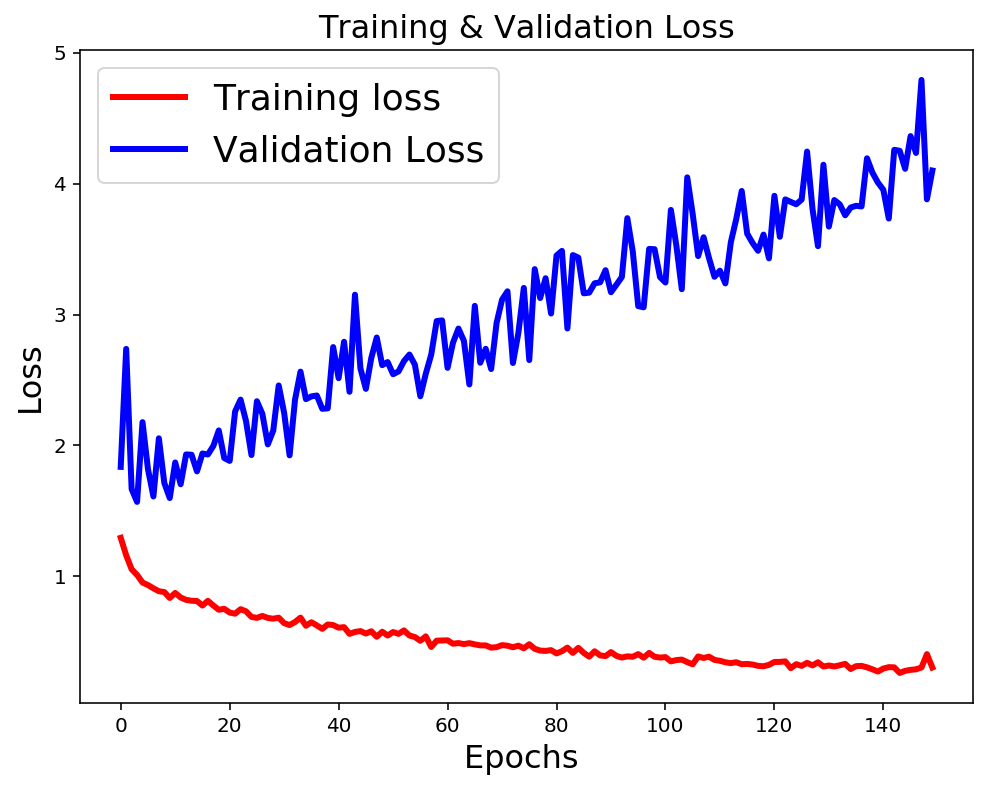

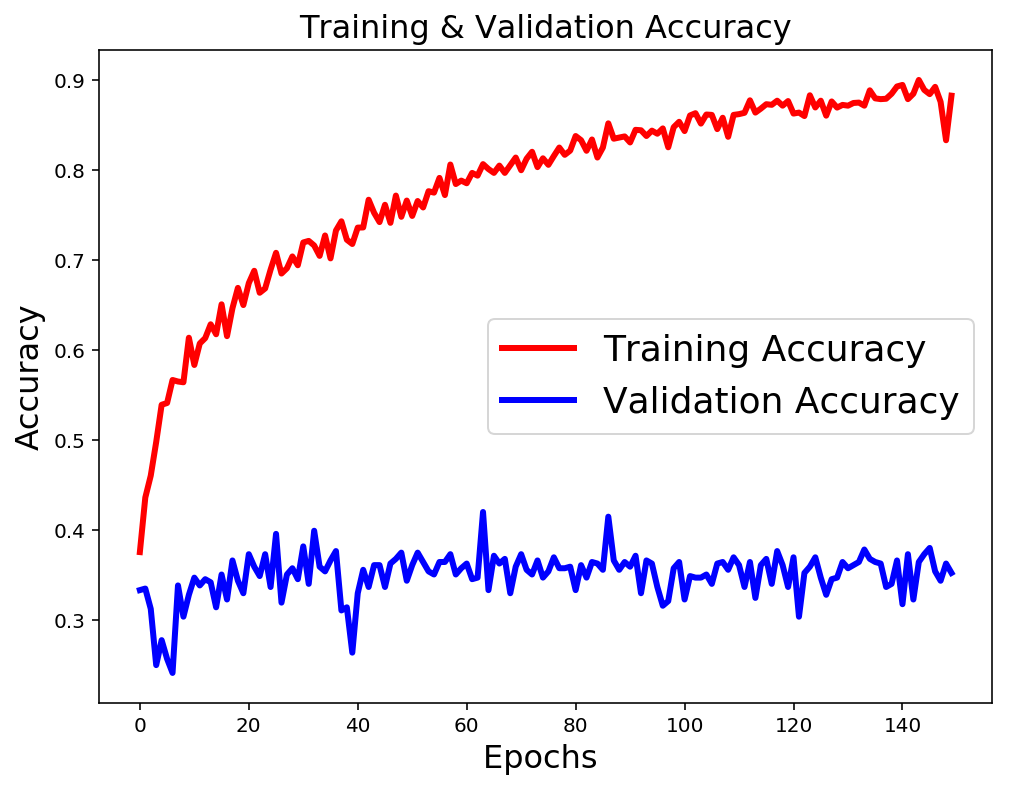

In [8]:
# Loss Curves
plt.figure(figsize=[8,6])
plt.plot(hist.history['loss'],'r',linewidth=3.0)
plt.plot(hist.history['val_loss'],'b',linewidth=3.0)
plt.legend(['Training loss', 'Validation Loss'],fontsize=18)
plt.xlabel('Epochs ',fontsize=16)
plt.ylabel('Loss',fontsize=16)
plt.title('Training & Validation Loss',fontsize=16)
 
# Accuracy Curves
plt.figure(figsize=[8,6])
plt.plot(hist.history['acc'],'r',linewidth=3.0)
plt.plot(hist.history['val_acc'],'b',linewidth=3.0)
plt.legend(['Training Accuracy', 'Validation Accuracy'],fontsize=18)
plt.xlabel('Epochs ',fontsize=16)
plt.ylabel('Accuracy',fontsize=16)
plt.title('Training & Validation Accuracy',fontsize=16)

In [16]:
test_path = 'dataset_upper/test'
test_batches = ImageDataGenerator().flow_from_directory(test_path, target_size = (128, 128), 
                                                         classes=['blouse','dress','tee'],
                                                                   batch_size = 90)

Found 90 images belonging to 3 classes.


In [17]:
test_imgs, test_labels = next(test_batches)
batch_pred = model.predict_generator(test_batches, steps=1)

In [18]:
# Compute confusion matrix
from sklearn.metrics import classification_report,confusion_matrix
cnf_matrix = confusion_matrix(np.argmax(test_labels, axis=1), np.argmax(batch_pred, axis=1))
np.set_printoptions(precision=2)
cnf_matrix

array([[ 0,  0, 30],
       [ 0,  0, 30],
       [ 0,  0, 30]], dtype=int64)

Confusion matrix, without normalization
[[ 0  0 30]
 [ 0  0 30]
 [ 0  0 30]]


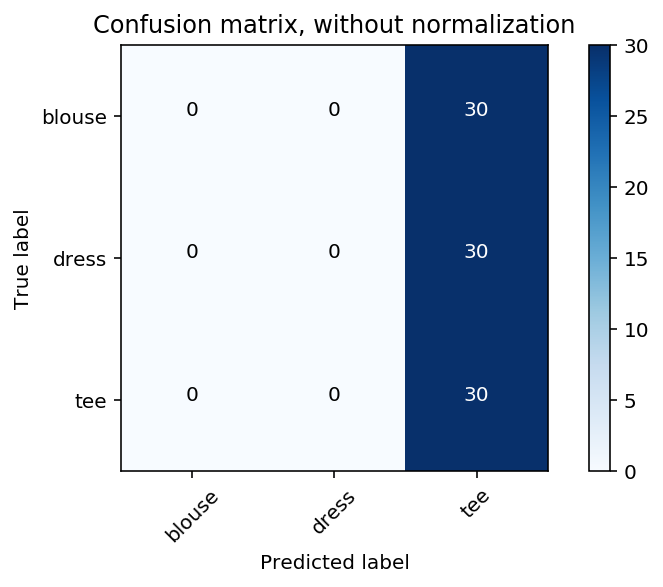

In [19]:
# Plot non-normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=['blouse','dress','tee'],
                      title='Confusion matrix, without normalization')

In [20]:
classes=['blouse','dress','tee']
print(classification_report(np.argmax(test_labels, axis=1), np.argmax(batch_pred, axis=1),target_names=classes))

             precision    recall  f1-score   support

     blouse       0.00      0.00      0.00        30
      dress       0.00      0.00      0.00        30
        tee       0.33      1.00      0.50        30

avg / total       0.11      0.33      0.17        90



c:\users\default.laptop-2ci68m4p\anaconda3\envs\tensorflow1\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


## Conclusion


In [21]:
training_set.class_indices

{'blouse': 0, 'dress': 1, 'tee': 2}

In [22]:
test_batches.class_indices

{'blouse': 0, 'dress': 1, 'tee': 2}

In [24]:
model.save('model3.h5')